# Setup and Data Download


In [1]:
import time
import copy
import os
import scipy.io
import shutil
import tarfile
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")

Using device: cuda:0


In [3]:
SPLIT_SEEDS = [42, 123, 1337]

# Define paths
DATA_DIR = './data'
FLOWERS_DIR = os.path.join(DATA_DIR, 'flowers102')
IMAGES_DIR = os.path.join(FLOWERS_DIR, 'jpg')

BATCH_SIZE = 32
NUM_CLASSES = 102

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# Create directories
os.makedirs(FLOWERS_DIR, exist_ok=True)

# Check if data already exists to avoid re-downloading
if not os.path.exists(IMAGES_DIR):
    # URLs for Oxford 102 dataset [cite: 9]
    # Note: Using the direct links usually found on the Oxford website
    print("Downloading dataset...")
    download_url('https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz', FLOWERS_DIR)
    download_url('https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat', FLOWERS_DIR)

    # Extract images
    print("Extracting images...")
    with tarfile.open(os.path.join(FLOWERS_DIR, '102flowers.tgz'), 'r:gz') as tar:
        tar.extractall(path=FLOWERS_DIR, filter='data')
    print("Dataset setup complete.")
else:
    print("Dataset already exists.")

Dataset already exists.


In [6]:
# 1. Load Labels (1-102)
mat = scipy.io.loadmat(os.path.join(FLOWERS_DIR, 'imagelabels.mat'))
labels = mat['labels'][0] - 1  # Adjust to 0-indexed (0 to 101)
labels

array([76, 76, 76, ..., 61, 61, 61], dtype=uint8)

In [7]:
# 2. Load Filenames
# Get all image filenames (they are sequentially named image_00001.jpg, etc.)
image_files = sorted(os.listdir(IMAGES_DIR))

In [8]:
# 3. Create Master DataFrame
# We preserve the original index automatically
flowers_df = pd.DataFrame({'FilePath': image_files, 'Category': labels})
flowers_df

,FilePath,Category
0,image_00001.jpg,76
1,image_00002.jpg,76
2,image_00003.jpg,76
3,image_00004.jpg,76
4,image_00005.jpg,76
...,...,...
8184,image_08185.jpg,61
8185,image_08186.jpg,61
8186,image_08187.jpg,61
8187,image_08188.jpg,61


In [9]:
labels_count_values = flowers_df['Category'].value_counts().sort_index(ascending=True)
labels_count_values

,count
Category,
0,40
1,60
2,40
3,56
4,65
...,...
97,82
98,63
99,49


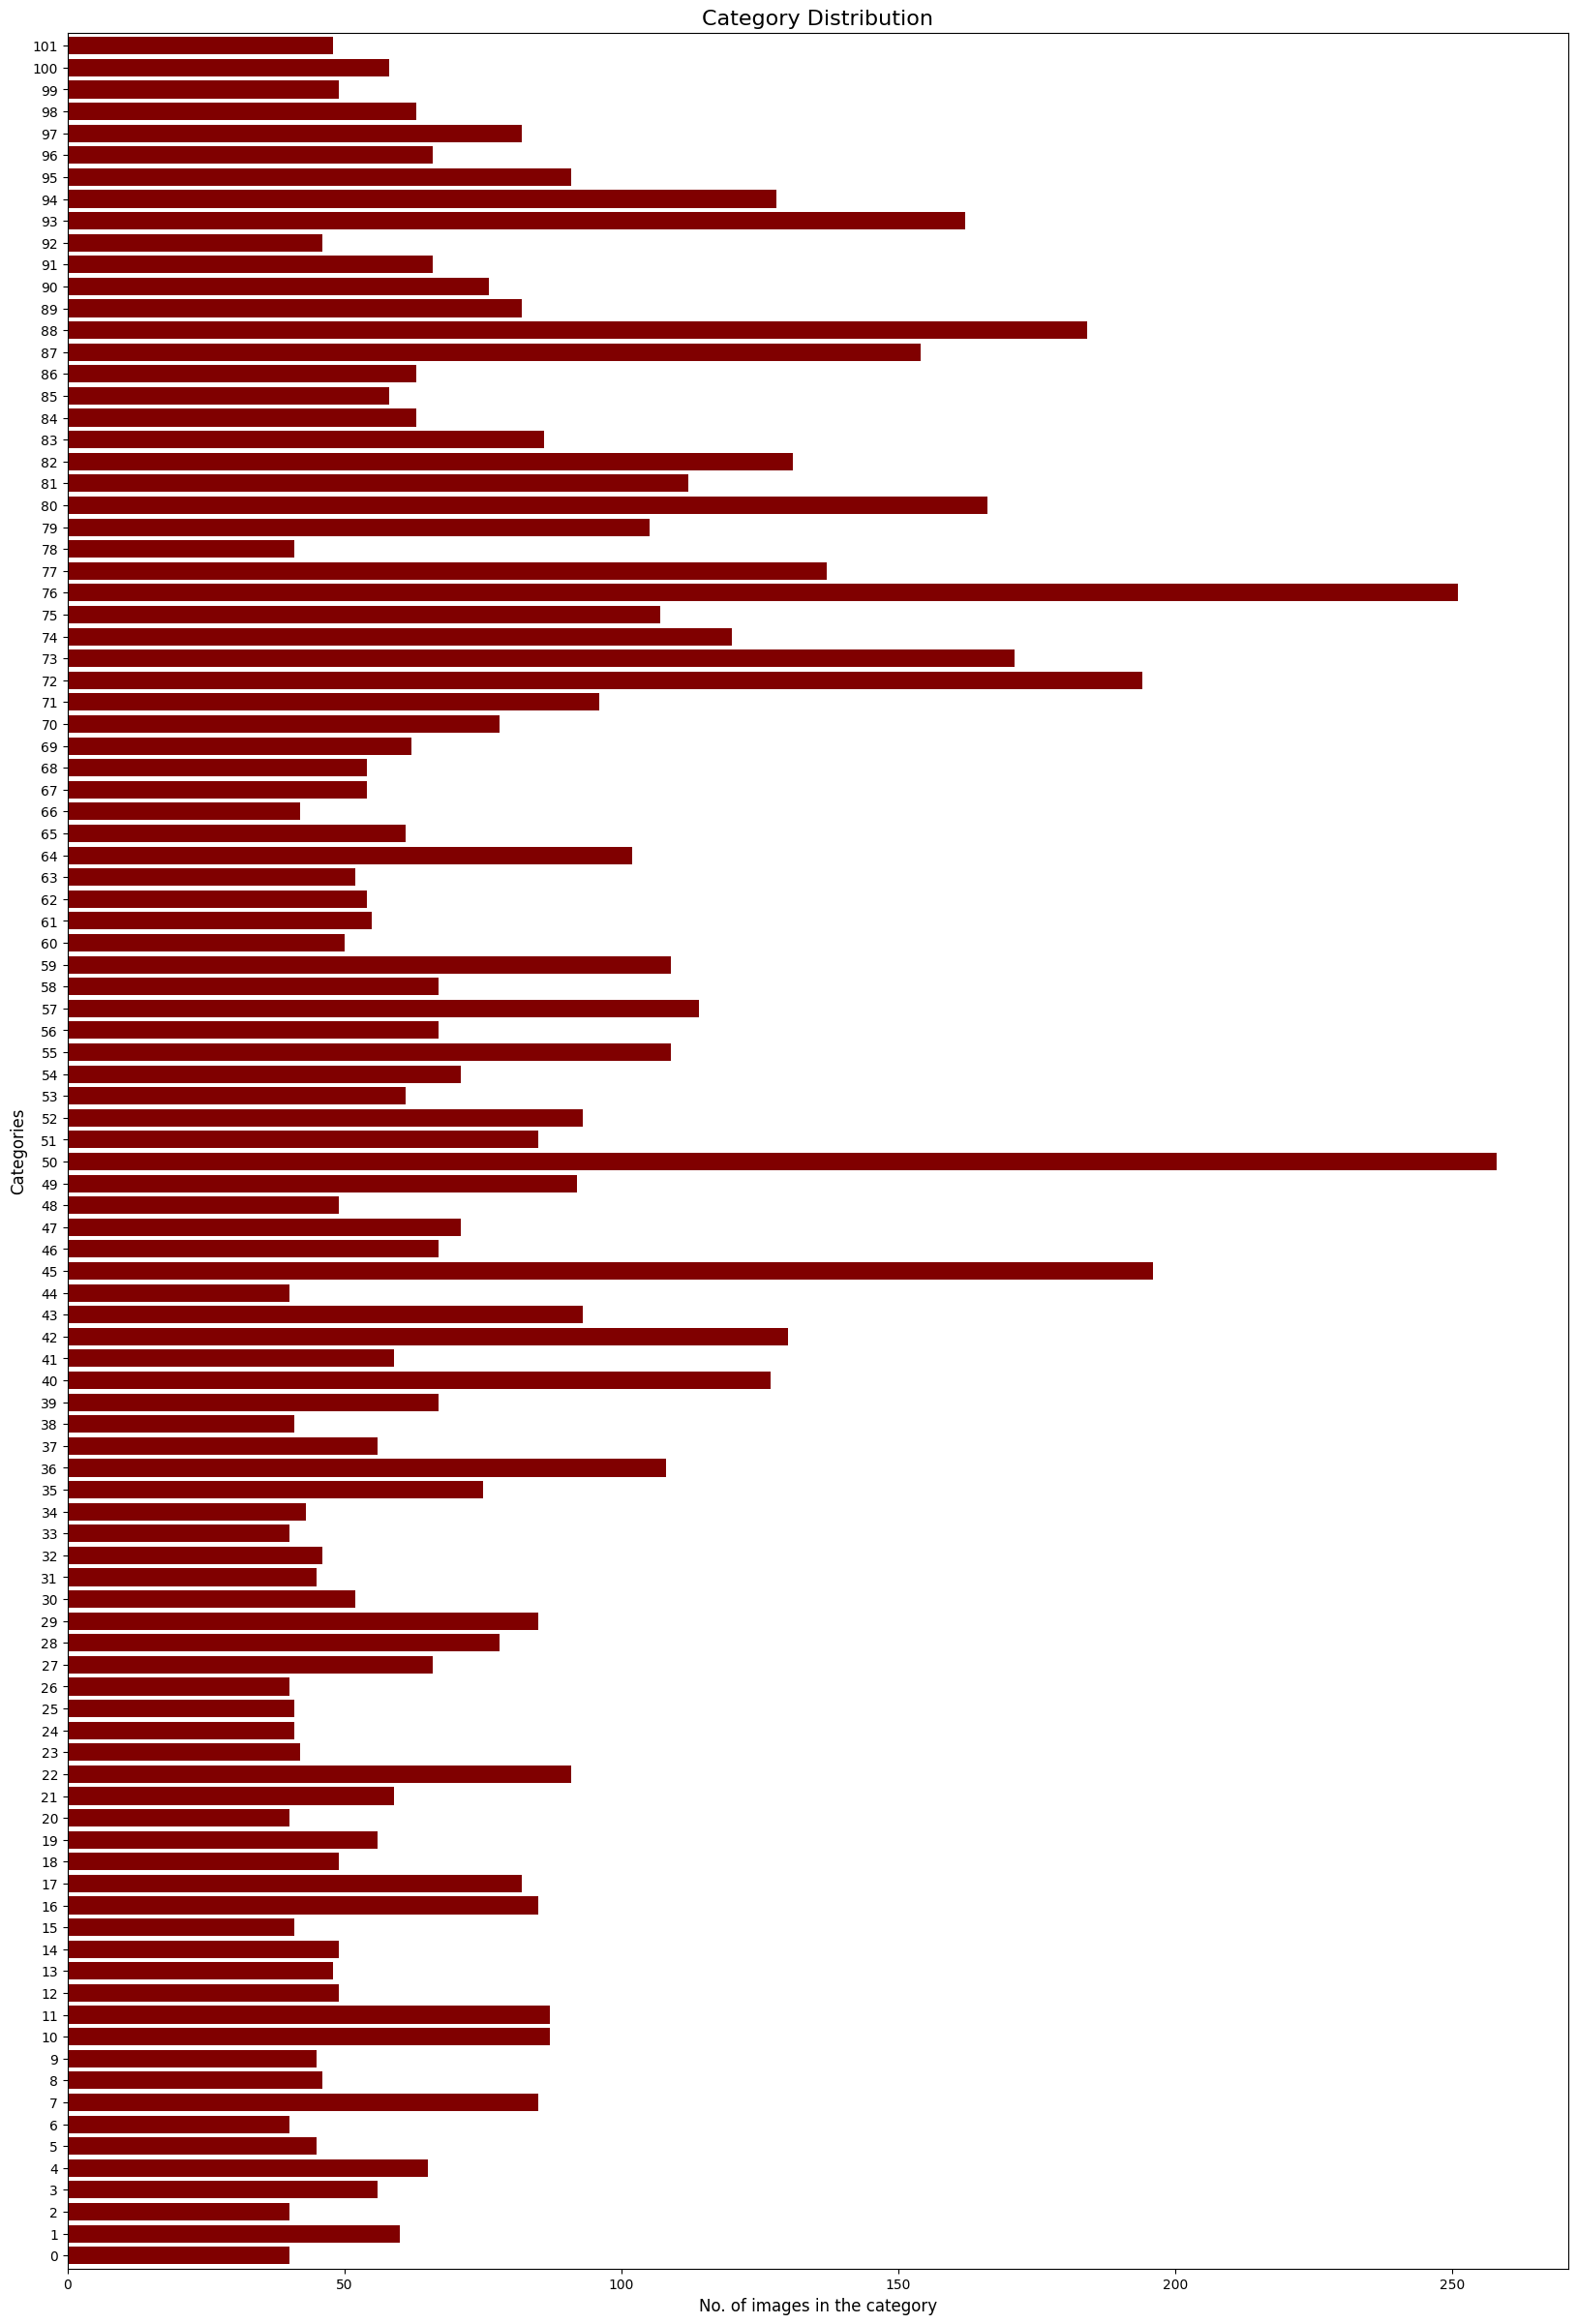

In [10]:
fig = plt.figure(figsize=(20, 30))

# creating the bar plot
plt.barh(labels_count_values.index, labels_count_values, color='maroon')

plt.yticks(labels_count_values.index)
plt.xlabel("No. of images in the category", fontsize=12)
plt.ylabel("Categories", fontsize=12)
plt.title("Category Distribution", fontsize=16)

plt.ylim(-0.6, len(labels_count_values) - 0.4)

plt.show()

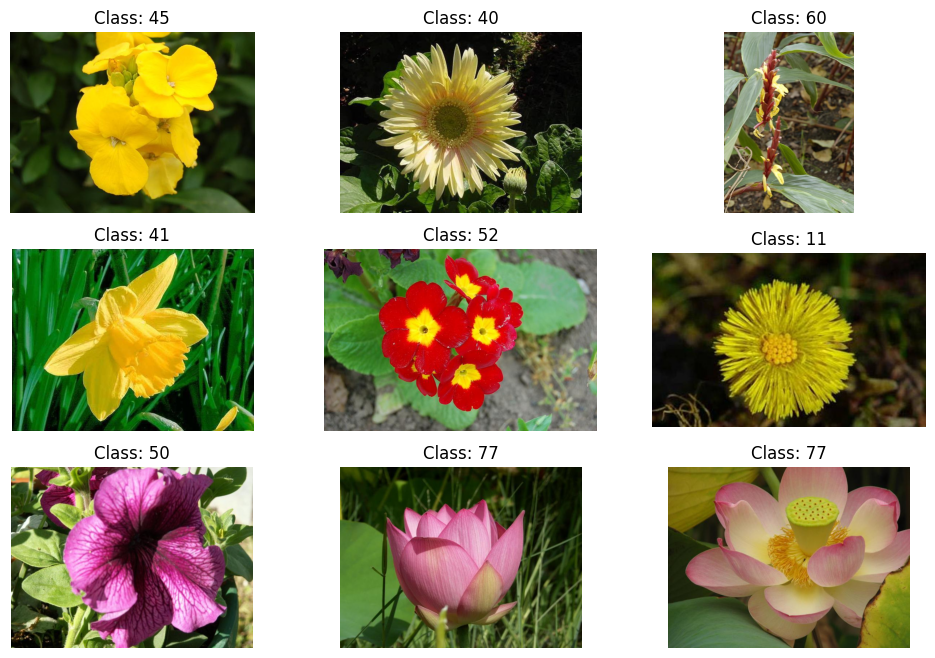

In [11]:
plt.figure(figsize=(12,8))

random_image = flowers_df.sample(n=9)
random_image_paths = random_image['FilePath'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = Image.open(os.path.join(IMAGES_DIR, path))
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+ str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# Dataset Class

In [12]:
class FlowersDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        """
        data_dir: Path to the folder containing the images (e.g., ./data/flowers102/jpg)
        labels_df: The DataFrame containing ['FilePath', 'Category']
        transform: PyTorch transforms
        """
        self.labels = labels
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]

        img_path = os.path.join(self.data_dir, row['FilePath'])

        # Open and ensure RGB (some images might be grayscale)
        image = Image.open(img_path).convert("RGB")

        # Get label and original index
        label = row['Category']

        if self.transform:
            image = self.transform(image)

        return image, label

In [13]:
TRAIN_TRANSFORMER = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(20),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
VAL_TEST_TRANSFORMER = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

# Train and Evaluate Loops

In [14]:
def train_loop(data_loader, model, device, loss_fn, optimizer, print_every_n=20):
    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    size = len(data_loader.sampler)

    t1 = time.time()

    for batch, (X, y) in enumerate(data_loader):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).long()

        optimizer.zero_grad()

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

        total_correct += (pred.argmax(dim=1) == y).sum().item()

        if batch % print_every_n == 0:
            t2 = time.time()
            print(f'\t[{total_samples:>5d}/{size:>5d}] | Loss: {loss.item():.3f} | Time: {t2-t1:.2f}s')
            t1 = time.time()

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)

    print(f'Train Result: Accuracy: {avg_acc:.4f}, Avg Loss: {avg_loss:.4f}')

    return avg_loss, avg_acc

In [15]:
def evaluate_loop(data_loader, model, device, loss_fn, eval_loop_result):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).long()

            pred = model(X)
            test_loss = loss_fn(pred, y)

            bs = y.size(0)
            total_loss += test_loss.item() * bs
            total_samples += bs

            y_pred = pred.argmax(dim=1)
            total_correct += (y_pred == y).sum().item()

    avg_loss = total_loss / max(1, total_samples)
    avg_acc = total_correct / max(1, total_samples)

    print(f'{eval_loop_result} Result: Accuracy: {avg_acc:.4f}, Avg Loss: {avg_loss:.4f}')

    return avg_loss, avg_acc

In [16]:
def epoch_loop(train_data_loader, val_data_loader, test_data_loader, model_name, model, loss_fn, optimizer, epochs_num=15, patience=10, min_delta=1e-4, device=DEVICE):
    print(f"{'='*60}\nSTARTING TRAINING: {model_name}\n{'='*60}")

    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []
    test_loss_history, test_acc_history = [], []

    start_time = time.time()

    for epoch in range(epochs_num):
        print(f"{'-'*25} Epoch {epoch+1} {'-'*25}")

        # --- TRAIN ---
        train_loss, train_acc = train_loop(train_data_loader, model, device, loss_fn, optimizer)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # --- VALIDATION ---
        val_loss, val_acc = evaluate_loop(val_data_loader, model, device, loss_fn, 'Validation')
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # ---- TEST ----
        test_loss, test_acc, *_ = evaluate_loop(test_data_loader, model, device, loss_fn, "Test")
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)

    total_time = time.time() - start_time
    print(f"\nTraining Complete in {total_time // 60:.0f}m {total_time % 60:.0f}s")

    return {
              "train_loss": train_loss_history,
              "train_acc": train_acc_history,
              "val_loss": val_loss_history,
              "val_acc": val_acc_history,
              "test_loss": test_loss_history,
              "test_acc": test_acc_history,
          }

# VGG19 Model

In [18]:
def build_vgg_model(num_classes=NUM_CLASSES, device=DEVICE):
    print("\n------ Loading VGG19 pretrained model ------\n")
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)

    # Freeze feature layers (Transfer Learning)
    for param in model.features.parameters():
        # param.requires_grad = True
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True

    # Modify the classifier
    # VGG19 classifier structure:
    # (0): Linear(in_features=25088, out_features=4096)
    # (3): Linear(in_features=4096, out_features=4096)
    # (6): Linear(in_features=4096, out_features=1000) -> Need to change this to 102

    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)

    return model.to(device)

In [19]:
vgg19_model = build_vgg_model()
vgg19_model


------ Loading VGG19 pretrained model ------



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# YOLOv5 Classification Model

In [20]:
# Clone the repository
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5

# Install dependencies
%pip install -qr yolov5/requirements.txt

print("YOLOv5 setup complete.")

YOLOv5 setup complete.


In [21]:
def build_yolo_model(num_classes=NUM_CLASSES, device=DEVICE):
    print("\n------ Building YOLOv5 Classification (Transfer: frozen backbone) ------\n")

    model = torch.hub.load("ultralytics/yolov5", "custom", path="yolov5s-cls.pt", force_reload=True)

    # 1) Find the LAST Linear layer and remember where it lives (parent module + attribute name)
    parent, attr, last_linear = None, None, None
    for name, m in model.named_modules():
        if isinstance(m, nn.Linear):
            last_linear = m
            # locate parent by splitting "path.to.layer"
            if name == "":
                continue
            parts = name.split(".")
            parent = model
            for p in parts[:-1]:
                parent = getattr(parent, p)
            attr = parts[-1]

    if last_linear is None:
        raise AttributeError("No nn.Linear layer found in YOLOv5 classification model.")

    # 2) Replace it with new classifier
    in_features = last_linear.in_features
    setattr(parent, attr, nn.Linear(in_features, num_classes))
    print(f"Replaced Linear '{attr}' (path='{name}') -> Linear(in={in_features}, out={num_classes})")

    # 3) Freeze all params
    for p in model.parameters():
        p.requires_grad = False

    # 4) Unfreeze ONLY the new head (the replaced Linear)
    for p in getattr(parent, attr).parameters():
        p.requires_grad = True

    return model.to(device)


In [22]:
yolov5_model = build_yolo_model()
yolov5_model


------ Building YOLOv5 Classification (Transfer: frozen backbone) ------

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2026-2-2 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Replaced Linear 'linear' (path='model.model.9.linear') -> Linear(in=1280, out=102)


DetectMultiBackend(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 

# Run Models For All Splits

In [25]:
# THINK ABOUT INCREASING THE EPOCHS NUMBER AND USE EARLY STOPPING!!
vgg19_results, yolov5_results = {}, {}

for idx, seed in enumerate(SPLIT_SEEDS, start=1):
    print(f"{'='*60}\nSTARTING SPLIT #{idx} WITH SEED {seed}\n{'='*60}")

    set_seed(seed=seed)

    # 1. Prepare Data for this specific seed (i)
    # Split: Train (50%) vs Temp (50%)
    train_df, temp_df = train_test_split(
        flowers_df, test_size=0.5, stratify=flowers_df['Category'], random_state=seed
    )

    # Split: Temp into Val (25%) and Test (25%)
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, stratify=temp_df['Category'], random_state=seed
    )

    print(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')

    train_dataset = FlowersDataset(data_dir=IMAGES_DIR, labels=train_df, transform=TRAIN_TRANSFORMER)
    val_dataset = FlowersDataset(data_dir=IMAGES_DIR, labels=val_df, transform=VAL_TEST_TRANSFORMER)
    test_dataset = FlowersDataset(data_dir=IMAGES_DIR, labels=test_df, transform=VAL_TEST_TRANSFORMER)

    train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # ------ VGG19 ------
    vgg19_model = build_vgg_model()
    optimizer_vgg19 = optim.SGD(
                                [p for p in vgg19_model.parameters() if p.requires_grad],
                                lr=1e-3,
                                momentum=0.9
                            )
    loss_fn_vgg19 = nn.CrossEntropyLoss()

    vgg19_results[f'Split_{idx}'] = epoch_loop(train_data_loader, val_data_loader, test_data_loader,
                                          'VGG19', vgg19_model, loss_fn_vgg19, optimizer_vgg19, epochs_num=25)

    # ------ YOLOv5 ------
    yolov5_model = build_yolo_model()
    optimizer_yolov5 = optim.SGD(
                                  [p for p in yolov5_model.parameters() if p.requires_grad],
                                  lr=1e-3,
                                  momentum=0.9
                              )
    loss_fn_yolov5 = nn.CrossEntropyLoss()

    yolov5_results[f'Split_{idx}'] = epoch_loop(train_data_loader, val_data_loader, test_data_loader, 'YOLOv5 Classification',
                                             yolov5_model, loss_fn_yolov5, optimizer_yolov5, epochs_num=25)

STARTING SPLIT #1 WITH SEED 42
Train: 4094 | Val: 2047 | Test: 2048

------ Loading VGG19 pretrained model ------

STARTING TRAINING: VGG19
------------------------- Epoch 1 -------------------------
	[   32/ 4094] | Loss: 4.633 | Time: 0.38s
	[  672/ 4094] | Loss: 4.421 | Time: 7.02s
	[ 1312/ 4094] | Loss: 3.987 | Time: 6.46s
	[ 1952/ 4094] | Loss: 3.928 | Time: 6.51s
	[ 2592/ 4094] | Loss: 3.546 | Time: 6.49s
	[ 3232/ 4094] | Loss: 3.644 | Time: 6.57s
	[ 3872/ 4094] | Loss: 2.897 | Time: 6.53s
Train Result: Accuracy: 0.1602, Avg Loss: 3.8652
Validation Result: Accuracy: 0.3683, Avg Loss: 2.7202
Test Result: Accuracy: 0.3716, Avg Loss: 2.7354
------------------------- Epoch 2 -------------------------
	[   32/ 4094] | Loss: 2.783 | Time: 0.32s
	[  672/ 4094] | Loss: 2.845 | Time: 6.45s
	[ 1312/ 4094] | Loss: 2.632 | Time: 6.40s
	[ 1952/ 4094] | Loss: 2.243 | Time: 6.44s
	[ 2592/ 4094] | Loss: 2.309 | Time: 6.47s
	[ 3232/ 4094] | Loss: 2.065 | Time: 6.38s
	[ 3872/ 4094] | Loss: 2.059 |

YOLOv5 🚀 2026-2-2 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Replaced Linear 'linear' (path='model.model.9.linear') -> Linear(in=1280, out=102)
STARTING TRAINING: YOLOv5 Classification
------------------------- Epoch 1 -------------------------
	[   32/ 4094] | Loss: 4.651 | Time: 0.27s
	[  672/ 4094] | Loss: 4.457 | Time: 4.45s
	[ 1312/ 4094] | Loss: 4.450 | Time: 4.54s
	[ 1952/ 4094] | Loss: 4.127 | Time: 4.43s
	[ 2592/ 4094] | Loss: 4.049 | Time: 4.47s
	[ 3232/ 4094] | Loss: 3.889 | Time: 4.55s
	[ 3872/ 4094] | Loss: 3.738 | Time: 4.45s
Train Result: Accuracy: 0.1273, Avg Loss: 4.1755
Validation Result: Accuracy: 0.2526, Avg Loss: 3.6784
Test Result: Accuracy: 0.2505, Avg Loss: 3.6848
------------------------- Epoch 2 -------------------------
	[   32/ 4094] | Loss: 3.730 | Time: 0.22s
	[  672/ 4094] | Loss: 3.389 | Time: 4.48s
	[ 1312/ 4094] | Loss: 3.514 | Time: 4.43s
	[ 1952/ 4094] | Loss: 3.355 | Time: 4.48s
	[ 2592/ 4094] | Loss: 3.562 | Time: 4.50s
	[ 3232/ 4094] | Loss: 3.628 | Time: 4.42s
	[ 3872/ 4094] | Loss: 2.820 | Time: 4.45s
Tra

YOLOv5 🚀 2026-2-2 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Replaced Linear 'linear' (path='model.model.9.linear') -> Linear(in=1280, out=102)
STARTING TRAINING: YOLOv5 Classification
------------------------- Epoch 1 -------------------------
	[   32/ 4094] | Loss: 4.841 | Time: 0.23s
	[  672/ 4094] | Loss: 4.550 | Time: 4.54s
	[ 1312/ 4094] | Loss: 4.425 | Time: 4.45s
	[ 1952/ 4094] | Loss: 4.276 | Time: 4.47s
	[ 2592/ 4094] | Loss: 4.073 | Time: 4.55s
	[ 3232/ 4094] | Loss: 3.938 | Time: 4.43s
	[ 3872/ 4094] | Loss: 3.801 | Time: 4.55s
Train Result: Accuracy: 0.1155, Avg Loss: 4.1973
Validation Result: Accuracy: 0.2687, Avg Loss: 3.6770
Test Result: Accuracy: 0.2534, Avg Loss: 3.6773
------------------------- Epoch 2 -------------------------
	[   32/ 4094] | Loss: 3.784 | Time: 0.23s
	[  672/ 4094] | Loss: 3.753 | Time: 4.55s
	[ 1312/ 4094] | Loss: 3.701 | Time: 4.59s
	[ 1952/ 4094] | Loss: 3.653 | Time: 4.46s
	[ 2592/ 4094] | Loss: 3.145 | Time: 4.56s
	[ 3232/ 4094] | Loss: 3.112 | Time: 4.53s
	[ 3872/ 4094] | Loss: 3.110 | Time: 4.43s
Tra

YOLOv5 🚀 2026-2-2 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 117 layers, 5447688 parameters, 0 gradients, 11.4 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


Replaced Linear 'linear' (path='model.model.9.linear') -> Linear(in=1280, out=102)
STARTING TRAINING: YOLOv5 Classification
------------------------- Epoch 1 -------------------------
	[   32/ 4094] | Loss: 4.669 | Time: 0.23s
	[  672/ 4094] | Loss: 4.463 | Time: 4.60s
	[ 1312/ 4094] | Loss: 4.423 | Time: 4.48s
	[ 1952/ 4094] | Loss: 4.073 | Time: 4.40s
	[ 2592/ 4094] | Loss: 4.003 | Time: 4.51s
	[ 3232/ 4094] | Loss: 3.467 | Time: 4.39s
	[ 3872/ 4094] | Loss: 4.229 | Time: 4.50s
Train Result: Accuracy: 0.1317, Avg Loss: 4.1691
Validation Result: Accuracy: 0.2819, Avg Loss: 3.6571
Test Result: Accuracy: 0.2842, Avg Loss: 3.6540
------------------------- Epoch 2 -------------------------
	[   32/ 4094] | Loss: 3.777 | Time: 0.23s
	[  672/ 4094] | Loss: 3.685 | Time: 4.41s
	[ 1312/ 4094] | Loss: 3.105 | Time: 4.51s
	[ 1952/ 4094] | Loss: 3.107 | Time: 4.45s
	[ 2592/ 4094] | Loss: 2.987 | Time: 4.46s
	[ 3232/ 4094] | Loss: 3.063 | Time: 4.58s
	[ 3872/ 4094] | Loss: 3.024 | Time: 4.51s
Tra

# Graphs

In [40]:
import matplotlib.pyplot as plt

def plot_performance(results_dict, model_name):
    """
    Plots Accuracy and Cross-Entropy Loss graphs for each split in the results dictionary.

    Args:
        results_dict (dict): Dictionary containing split data with keys:
                             'train_loss', 'train_acc', 'val_loss', 'val_acc' (lists)
                             and 'test_loss', 'test_acc' (scalars).
    """
    # Iterate through each split (e.g., 'Split_1', 'Split_2')
    for split_name, metrics in results_dict.items():

        # Extract data
        epochs = range(1, len(metrics['train_loss']) + 1)
        train_loss = metrics['train_loss']
        val_loss = metrics['val_loss']
        train_acc = metrics['train_acc']
        val_acc = metrics['val_acc']

        # Extract Test Scalars
        test_loss = metrics['test_loss']
        test_acc = metrics['test_acc']

        # Create a figure with two subplots (1 row, 2 columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'{split_name} Performance Metrics for {model_name}', fontsize=16, fontweight='bold')

        # --- Plot 1: Accuracy ---
        ax1.plot(epochs, train_acc, label='Train Accuracy', marker='o', linestyle='-', linewidth=2)
        ax1.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='-', linewidth=2)
        ax1.plot(epochs, test_acc, label='Test Accuracy', marker='o', linestyle='-', linewidth=2)

        ax1.set_title('Accuracy vs. Epochs')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)

        # --- Plot 2: Cross-Entropy Loss ---
        ax2.plot(epochs, train_loss, label='Train Loss', marker='o', linestyle='-', linewidth=2)
        ax2.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-', linewidth=2)
        ax2.plot(epochs, test_loss, label='Test Loss', marker='o', linestyle='-', linewidth=2)

        ax2.set_title('Cross-Entropy Loss vs. Epochs')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, linestyle='--', alpha=0.7)

        # Show the plot
        plt.tight_layout()
        plt.show()

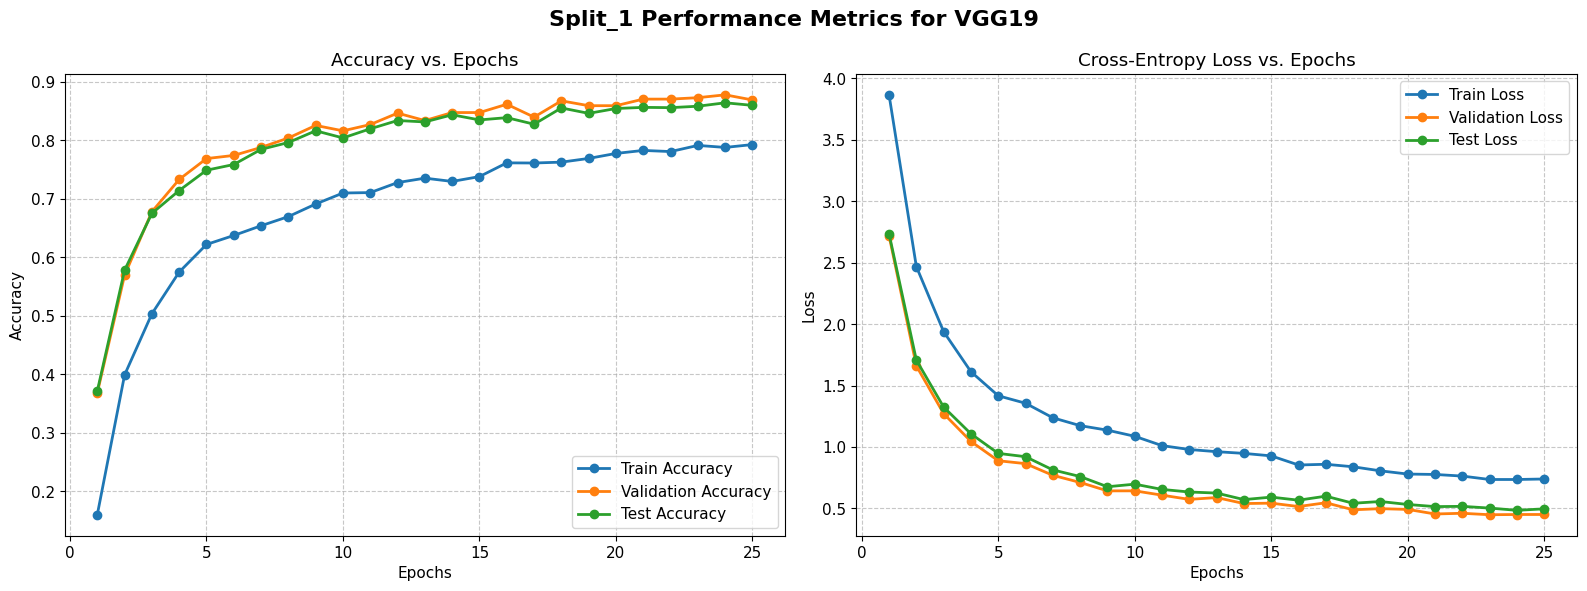

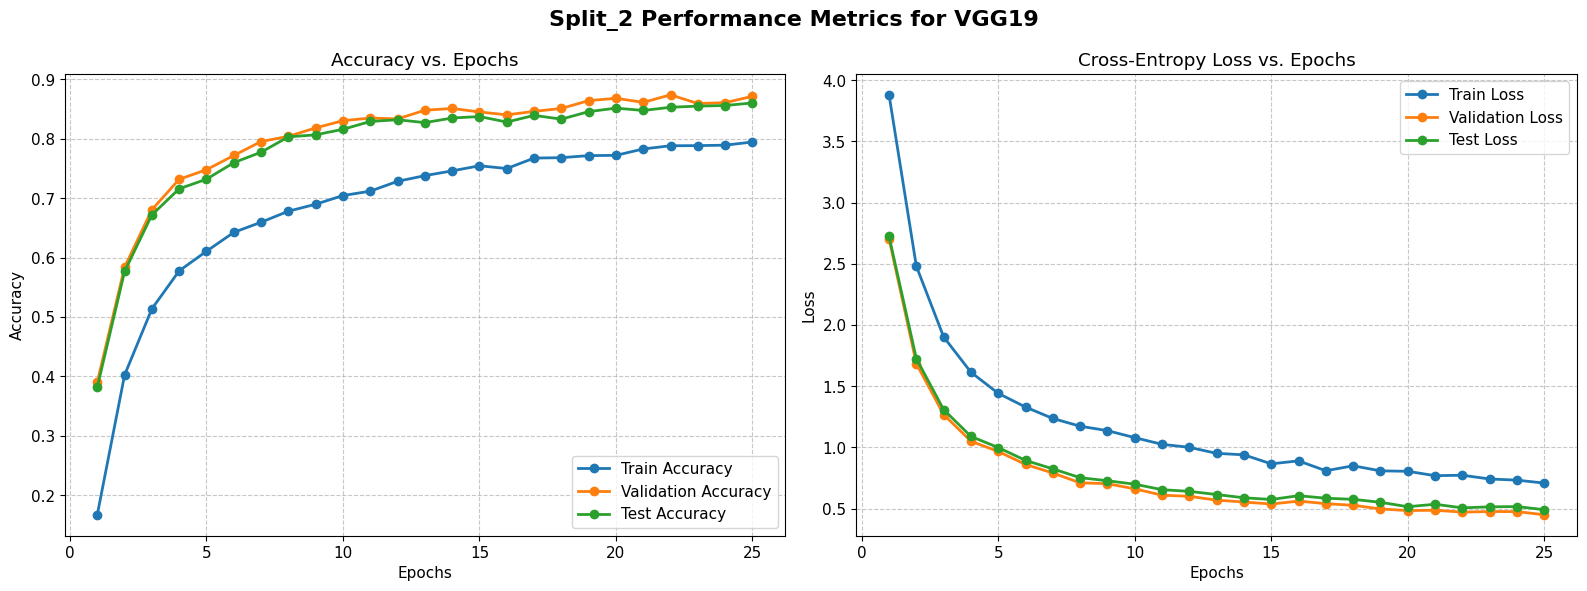

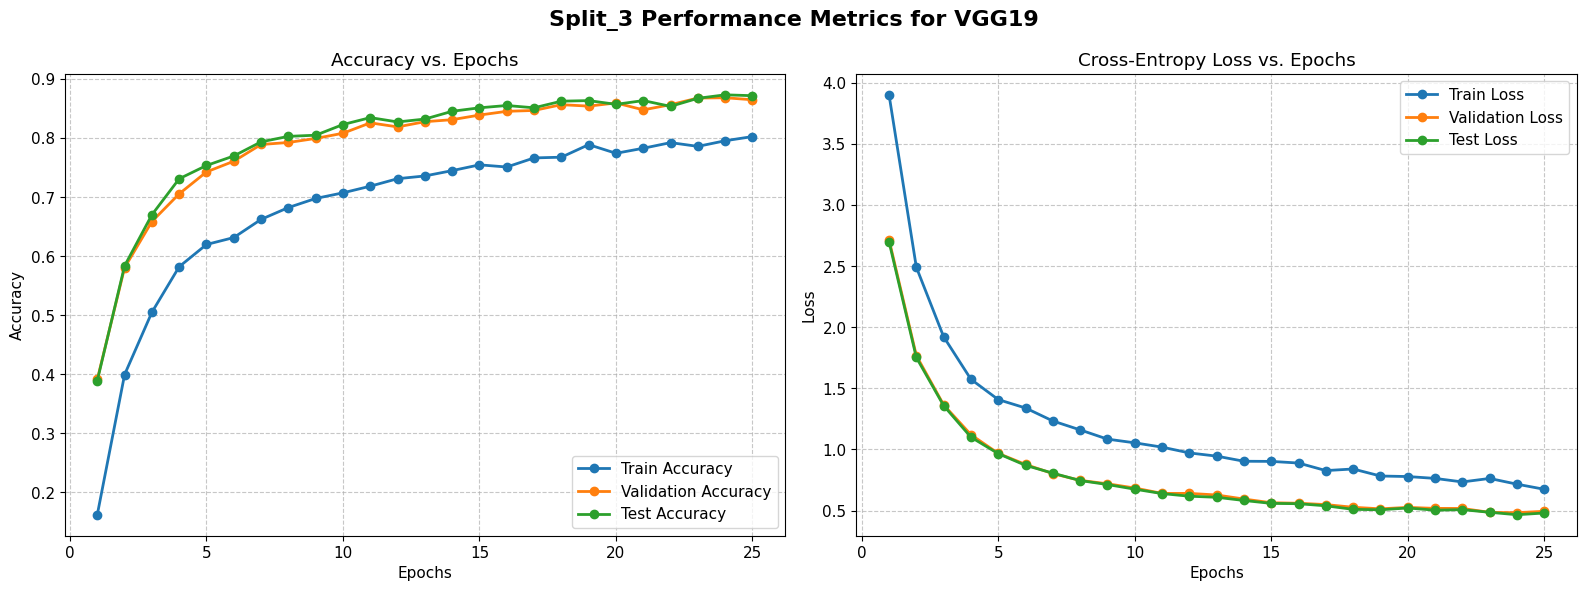

In [41]:
plot_performance(vgg19_results, 'VGG19')

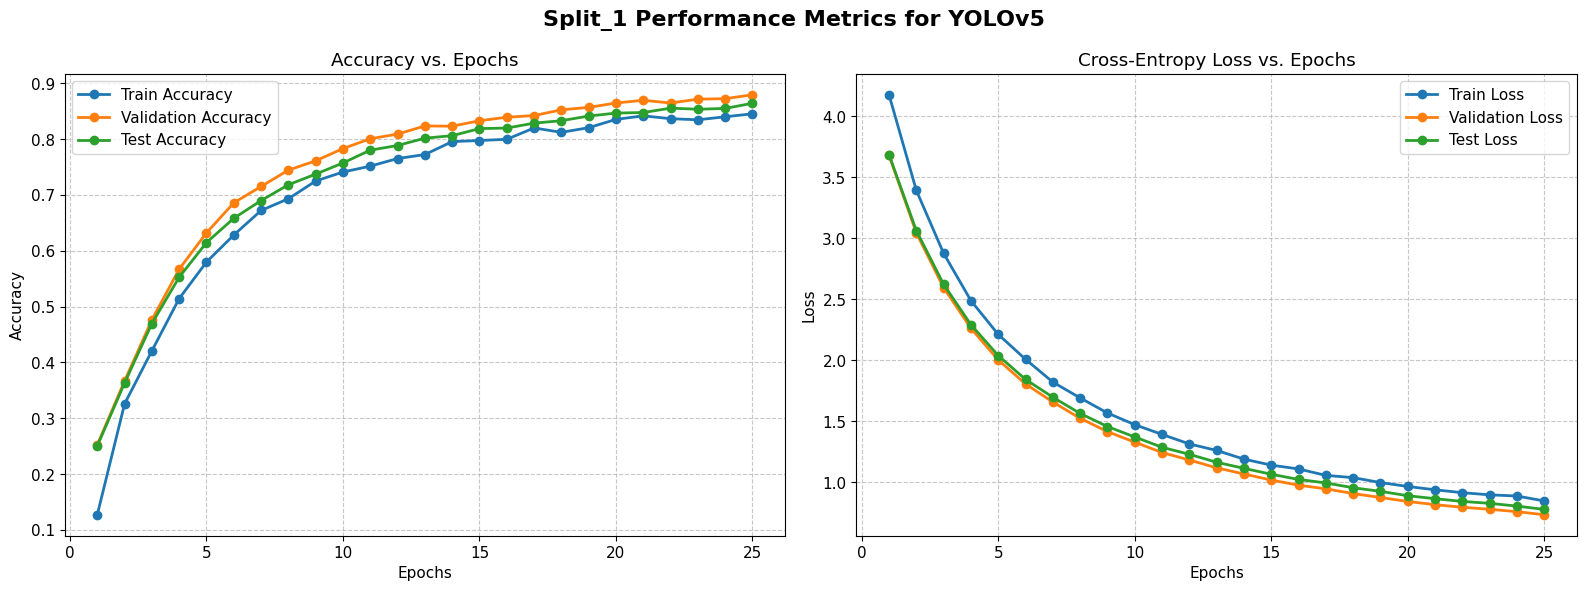

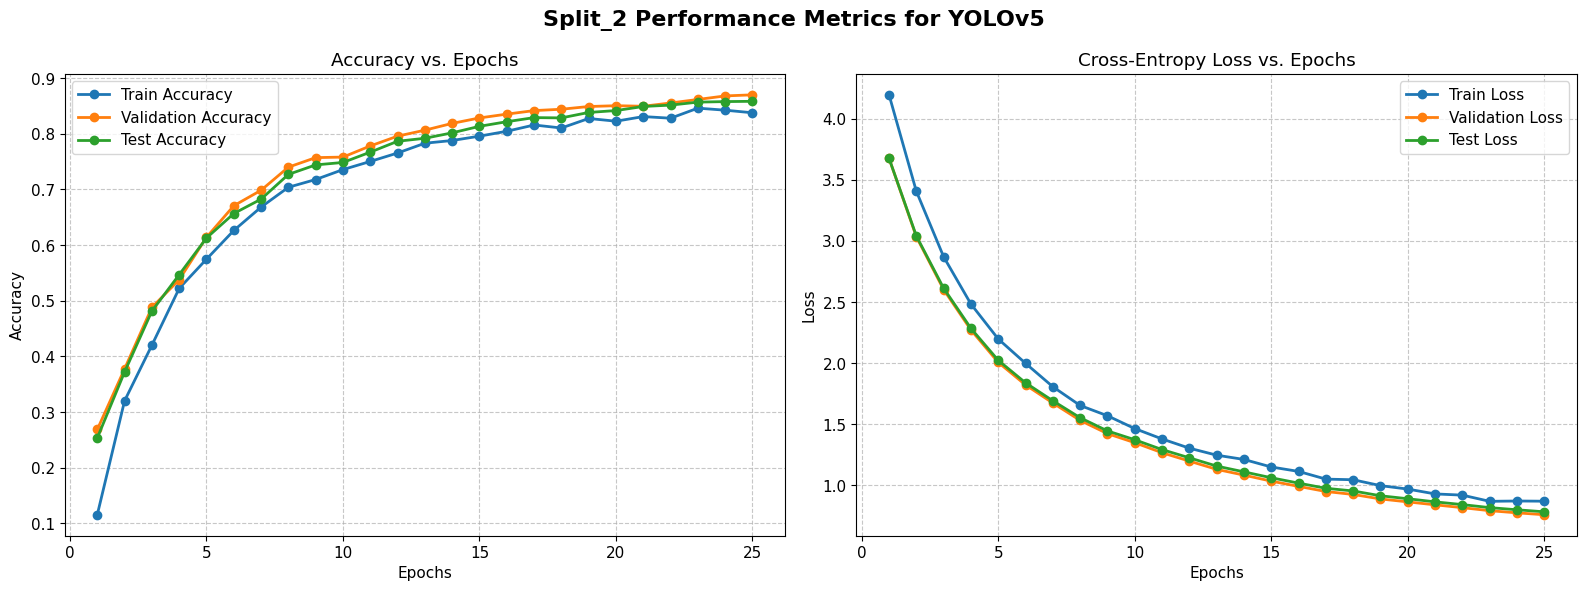

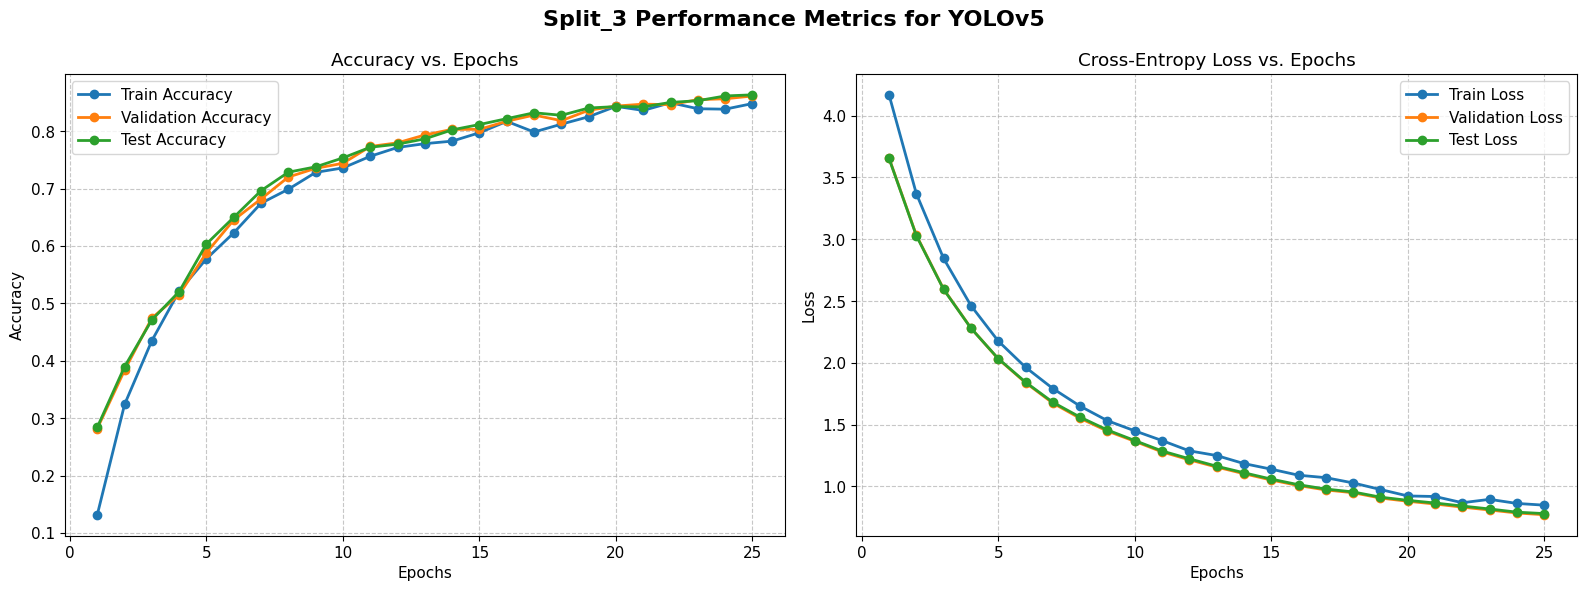

In [42]:
plot_performance(yolov5_results, 'YOLOv5')